2023-05-30 21:03:19.288899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


load from sample_hbb.csv
40000 events loaded.
load from sample_q.csv
40000 events loaded.
load from sample_test.csv
40000 events loaded.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1250/1250 [==============================] - 1s 1ms/step
(80000, 4)
(80000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


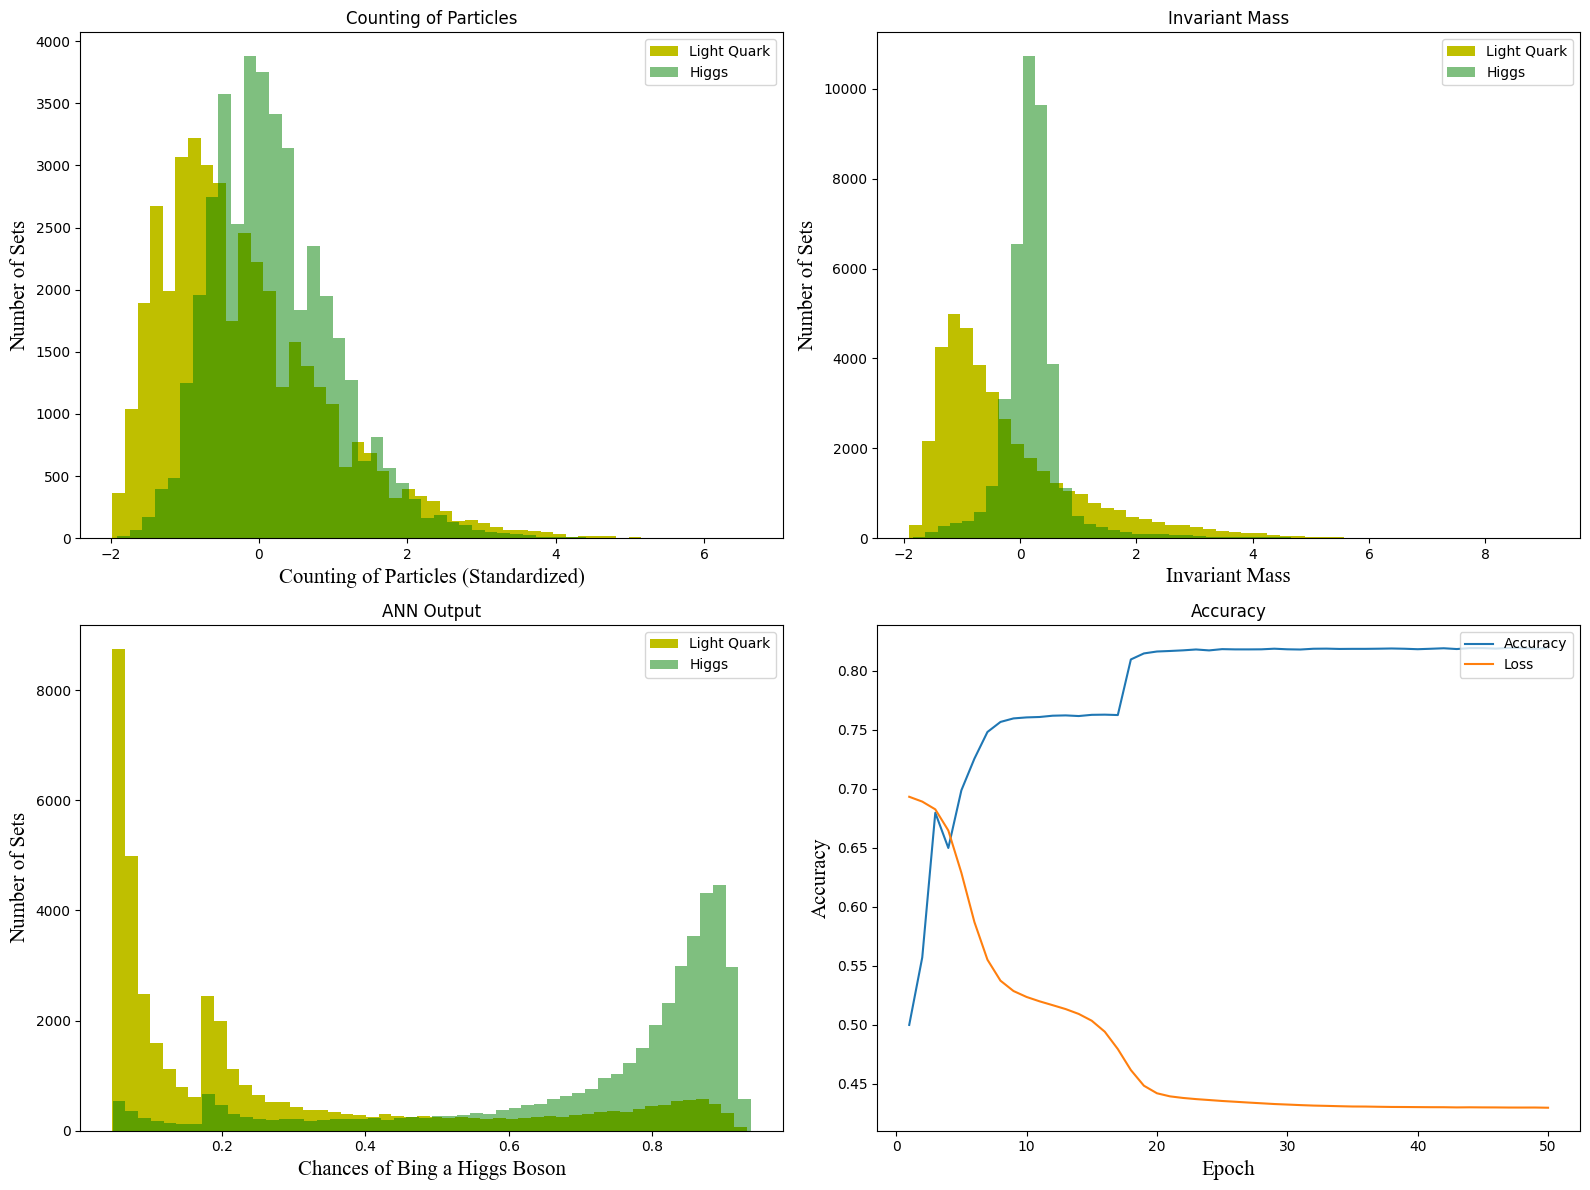

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from ann_visualizer.visualize import ann_viz;
from sklearn.preprocessing import StandardScaler


def load_samples(filename):
    print('load from',filename)
    fin = open(filename)
    lines = fin.readlines()
    idx_cur, samples, evt = -1, [], []
    for l in lines[1:]:
        idx, code, px, py, pz = l.split(',')
        if idx_cur!=int(idx):
            idx_cur=int(idx)
            if len(evt)>0:
                samples.append(evt)
                evt = []
        else:
            evt.append([int(code),float(px),float(py),float(pz)])
    samples.append(evt)
    print(len(samples),'events loaded.')
    return samples
    
def prepare_features(samples):
    features = []
    for evt in samples:
        px = py = pz = E = 0.
        count_id_zero = 0.
        count_id_three_plus_four = 0.
        for p in evt:
            px += p[1]
            py += p[2]
            pz += p[3]
            E += (p[1]**2+p[2]**2+p[3]**2)**0.5
            if p[0] == 0:
                count_id_zero += 1
            if p[0] == 3 or 4 :
                count_id_three_plus_four += 1
        M = (E**2 - (px**2+py**2+pz**2))**0.5
        features.append([len(evt), M, count_id_zero - 2, count_id_three_plus_four])
    return features
            
sample_sig = load_samples('sample_hbb.csv')
sample_bkg = load_samples('sample_q.csv')
sample_test = load_samples('sample_test.csv')




# Prepare the features
x_train = np.array(prepare_features(sample_sig) + prepare_features(sample_bkg))
y_train = np.array([1]*len(sample_sig)+[0]*len(sample_bkg))
x_test = np.array(prepare_features(sample_test))

# Initialize the Scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
x_train = scaler.fit_transform(x_train)

# Use the same scaler to transform the test data
x_test = scaler.transform(x_test)




model = Sequential()
model.add(Dense(units = 7, activation = 'sigmoid'))
model.add(Dense(units = 10, activation = 'sigmoid'))
model.add(Dense(units = 5, activation = 'sigmoid'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',
              optimizer = SGD(lr = 0.05),
              metrics = ['accuracy'])


num_of_epoch = 50
# 創建一個列表來記錄每個epoch的精確度
accuracy_list = []
loss_list = []

# 訓練模型並記錄每個epoch的精確度
for epoch in range(num_of_epoch):
    history = model.fit(x_train, y_train, epochs = 1, batch_size = 80)
    _, accuracy = model.evaluate(x_train, y_train)
    accuracy_list.append(accuracy)
    loss_list.append(history.history['loss'][0])

f_train = model.predict(x_train)

p_test = model.predict(x_test)
fout = open('my_predicts.csv','w')
fout.write("id,class\n")
for idx,p in enumerate(p_test):
    fout.write('%d,%d\n' % (idx,p>0.5))
fout.close()


ann_viz(model, title = "Higgs Boson Prediction NN Structure", view = True, filename = 'My_NN_Structure')



print(x_train.shape)
print(y_train.shape)

print(type(x_train))
print(type(y_train))

font1 = {'family':'times new roman','color':'black','size':20}
font2 = {'family':'times new roman','color':'black','size':15}


fig = plt.figure()
fig.set_size_inches(16, 12)

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.title.set_text('Counting of Particles')
ax1.hist(x_train[y_train == 0][:,0],label = 'Light Quark' , bins=50, color='y')
ax1.hist(x_train[y_train == 1][:,0],label = 'Higgs' , bins=50, color='g', alpha=0.5)
ax1.set_xlabel("Counting of Particles (Standardized)", fontdict = font2)
ax1.set_ylabel("Number of Sets", fontdict = font2)

ax2.title.set_text('Invariant Mass')
ax2.hist(x_train[y_train == 0][:,1],label = 'Light Quark' , bins=50, color='y')
ax2.hist(x_train[y_train == 1][:,1],label = 'Higgs' , bins=50, color='g', alpha=0.5)
ax2.set_xlabel("Invariant Mass", fontdict = font2)
ax2.set_ylabel("Number of Sets", fontdict = font2)

ax3.title.set_text('ANN Output')
ax3.hist(f_train[y_train == 0],label = 'Light Quark' , bins=50, color='y')
ax3.hist(f_train[y_train == 1],label = 'Higgs' , bins=50, color='g', alpha=0.5)
ax3.set_xlabel("Chances of Bing a Higgs Boson", fontdict = font2)
ax3.set_ylabel("Number of Sets", fontdict = font2)

ax4.title.set_text('Accuracy')  # 設置第四張子圖的標題
ax4.plot(range(1, num_of_epoch + 1), accuracy_list, label = 'Accuracy')
ax4.plot(range(1, num_of_epoch + 1), loss_list, label = 'Loss')
ax4.set_xlabel("Epoch", fontdict = font2)
ax4.set_ylabel("Accuracy", fontdict = font2)

ax1.legend(loc = 1)
ax2.legend(loc = 1)
ax3.legend(loc = 1)
ax4.legend(loc = 1)
fig.tight_layout()
plt.savefig("./Result.pdf" ,  dpi = 900, bbox_inches = 'tight')
# plt.show()